In [10]:
import datetime
import random

import numpy as np
import yaml
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
import csv

from utils.data_reading.features_extraction import STFTFeaturesExtractor, RelativeDWTFeaturesExtractor
from utils.data_reading.sound_file_manager import WavFilesManager
from utils.misc.misc import make_directory

## Parameters

In [11]:
yaml_path = "/home/plerolland/Bureau/OHASISBIO_dataset/data/dataset.yaml"

output_path = "/media/plerolland/LaBoite/PublicData/training/spectrograms"

# duration taken before and after the event for the output
delta_output = datetime.timedelta(seconds=100)

# type of data that we want
features_extractor = STFTFeaturesExtractor(None, vmin=-35, vmax=140)  # spectrograms generator
#features_extractor = RelativeDWTFeaturesExtractor(None)  # DWT features generator

random_offset_multiplicator = 1  # set to 0 if we want to center events

negatives_per_positive = 1  # number of negative samples that will be generated for each positive one

SEED = 0

## Initialization

In [12]:
random.seed(SEED)

with open(yaml_path, "r") as f:
    params = yaml.load(f, Loader=yaml.BaseLoader)["train_dataset"]
wav_prefix = params["wav_root_dir"]
csv_prefix = params["csv_root_dir"]
studies = params["studies"]
stations = list(params["stations"].keys())

dataset_csv_path = f"{output_path}/dataset.csv"

dates = {}
levels = {}
levels_per_study = {}
levels_per_station = {h : [] for h in stations}
managers = {h : WavFilesManager(f"{wav_prefix}/{h}") for h in stations}

make_directory(output_path)
make_directory(f"{output_path}/positives")
make_directory(f"{output_path}/negatives")

## Data loading

In [13]:
for s_name, s in studies.items():
    sts = s["stations"]
    dates[s_name] = {h : [] for h in sts}
    levels[s_name] = {h : [] for h in sts}
    levels_per_study[s_name] = []
    with open(f"{csv_prefix}/{s_name}.csv") as f:
        csv_reader = csv.reader(f, delimiter=",")
        next(csv_reader) # skip first line which contains column names
        lines = list(csv_reader)
    for line in lines:
        station = line[0]
        date = datetime.datetime.strptime(line[1], "%Y%m%d_%H%M%S.%f")
        level = float(line[2])
        dates[s_name][station].append(date)
        levels[s_name][station].append(level)
        levels_per_study[s_name].append(level)
        levels_per_station[station].append(level)

## Plots

Text(0.5, 1.0, 'received levels per study')

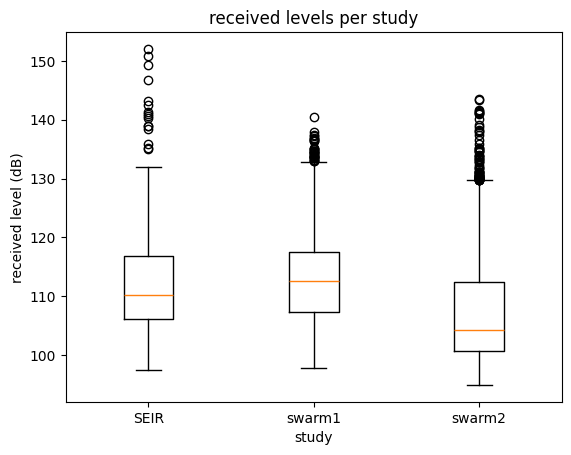

In [14]:
plt.boxplot(list(levels_per_study.values()))
plt.xticks(list(range(1,len(studies)+1)), list(levels_per_study.keys()))
plt.xlabel("study")
plt.ylabel("received level (dB)")
plt.title("received levels per study")

Text(0.5, 1.0, 'received levels per station')

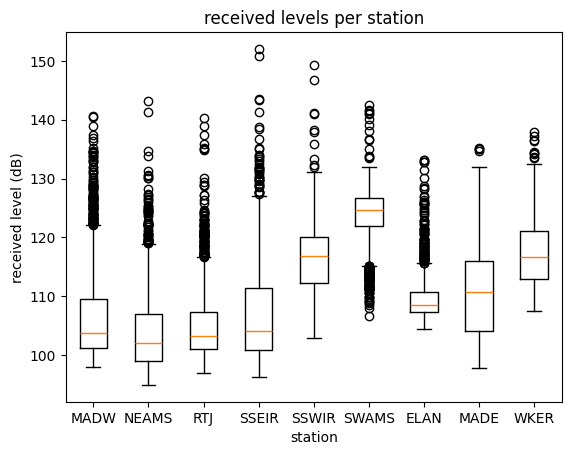

In [15]:
plt.boxplot(list(levels_per_station.values()))
plt.xticks(list(range(1,len(list(levels_per_station.keys()))+1)), list(levels_per_station.keys()))
plt.xlabel("station")
plt.ylabel("received level (dB)")
plt.title("received levels per station")

## Dataset creation

### Positives

In [16]:
paths = {station: [] for station in stations}
segments_to_save = {station: [] for station in stations}

dataset_csv_data = ""

for s_name, s in studies.items():
    make_directory(f"{output_path}/positives/{s_name}")
    for station, d in dates[s_name].items():
        make_directory(f"{output_path}/positives/{s_name}/{station}")
        
        d = np.sort(d)
        for i in range(len(d)):
            paths[station].append(f'{output_path}/positives/{s_name}/{station}/{d[i].strftime("%Y%m%d_%H%M%S")}.{features_extractor.EXTENSION}')
            dataset_csv_data += f"{paths[station][-1]},positive"
            
            offset = (random.random()-0.5) * 1.9 * delta_output * random_offset_multiplicator
            segments_to_save[station].append((d[i] + offset - delta_output, d[i] + offset + delta_output))
            
            j=i # look for events before this one that may appear in the window
            while j>=0 and abs(d[j] - (d[i] + offset)) < delta_output:
                event_pos = d[j] - (d[i] + offset)
                dataset_csv_data += f",{event_pos.total_seconds():.1f}"
                j -= 1
            j=i+1 # look for events after this one that may appear in the window
            while j<len(d) and abs(d[j] - (d[i] + offset)) < delta_output:
                event_pos = d[j] - (d[i] + offset)
                dataset_csv_data += f",{event_pos.total_seconds():.1f}"
                j += 1
            dataset_csv_data += "\n"

for station in tqdm(paths.keys()):
    features_extractor.manager = managers[station]
    starts, ends = zip(*segments_to_save[station])
    features_extractor.save_features_batch(starts, ends, paths[station])

100%|██████████| 9/9 [02:08<00:00, 14.30s/it]


### Negatives

In [17]:
paths = {station: [] for station in stations}
segments_to_save = {station: [] for station in stations}

for s_name, s in studies.items():
    make_directory(f"{output_path}/negatives/{s_name}")
    start_date = datetime.datetime.strptime(params["studies"][s_name]["date_start"], "%Y%m%d_%H%M%S")
    end_date = datetime.datetime.strptime(params["studies"][s_name]["date_end"], "%Y%m%d_%H%M%S")
    duration_s = (end_date - start_date).total_seconds()
    for station, d in dates[s_name].items():
        make_directory(f"{output_path}/negatives/{s_name}/{station}")
        
        d = np.array([(di - start_date).total_seconds() for di in d])
        already_generated = []
        for i in range(len(d)):
            # we can save some negatives
            for j in range(negatives_per_positive):
                # generate random dates until we are far enough from annotations and from previously selected dates
                
                while True:
                    res = random.randint(0, duration_s)
                    if np.min(np.abs(res - d)) > 1.5*delta_output.total_seconds():
                        if len(already_generated) == 0 or np.min(np.abs(np.array(already_generated) - res)) > 1.5*delta_output.total_seconds():
                            already_generated.append(res)
                            di = start_date + datetime.timedelta(seconds=res)
                            paths[station].append(f'{output_path}/negatives/{s_name}/{station}/{di.strftime("%Y%m%d_%H%M%S")}.{features_extractor.EXTENSION}')
                            dataset_csv_data += f"{paths[station][-1]},negative\n"
                            segments_to_save[station].append((di-delta_output, di+delta_output))
                            break

for station in tqdm(paths.keys()):
    features_extractor.manager = managers[station]
    starts, ends = zip(*segments_to_save[station])
    features_extractor.save_features_batch(starts, ends, paths[station])

100%|██████████| 9/9 [00:00<00:00, 85.78it/s]


In [18]:
with open(dataset_csv_path, "w") as f:
    f.write(dataset_csv_data[:-1])  # write the list of all created files, removing last \n character